# HMDA Data Analysis and Prediction Model
__By Kyoosik Kim__

Home Mortgage Disclosure Act ([HMDA](https://www.consumerfinance.gov/data-research/hmda/learn-more)) is a federal law in the US that requires financial institutions to provide mortgage data to the public. The data contains basic information regarding mortgage loans such as applicant's income and race, loan amount, regions, and many others. What we focus is the relationship between these factors and the result of evaluation. There are 6 different available results, among which approval and denial are the major counts. Through the analysis, we will find patterns in numerical and categorical features, and eventually apply them to building a predictive model.

> 1. __Setup and Query Dataset__
> 2. __Preparation__
> 3. __Data Cleaning__: *category reduction, type conversion*
> 4. __Data Analysis__: *scatterplot, boxplot*
> 5. __Clustering__: *hierarchical, density-based*
> 6. __Modeling__: *decision tree, naive bayes, randomforest, svc*
> 7. __Conclusion__

------

## 1. Setup and Query Dataset
The data is pulled directly from the [CFPB](https://cfpb.github.io/api/hmda/basics.html) API. Although downloading in CSV is also available on [Custom Dataset](https://www.consumerfinance.gov/data-research/hmda/explore) page at the same website, API has a benefit of flexibility like querying data. The data set is HMDA data of St. Louis where social issues often arise such as racial discrimination or high crime rate. The data format is JSON to be able to fit MongoDB so that we can query the data fast. The purpose of querying is to learn which features to keep or throw out before analysis. The following are libraries to be used for the entire project.

In [1]:
# file control, api, mongodb
import json
import os
import urllib3
from pymongo import MongoClient
#from bson.json_util import dumps
#from bson import json_util

# dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc

# model preparation
from sklearn import preprocessing as ppr
from sklearn.model_selection import train_test_split

# modeling
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

# others
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Program Files\Python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
""" 
year, state, county can be given as condition
pull all the features in JSON
save the result as a file for later use
"""
def pull_dataset(file_name, year, state_code, county_code):
    http = urllib3.PoolManager()
    # request if file doesn't exist
    if not os.path.isfile(file_name):
        cfpb_url = ('https://api.consumerfinance.gov/data/hmda/slice/hmda_lar.json?&'
            '$where=as_of_year+IN+('+year+')+AND+((state_code='+state_code+'+AND+county_code+IN+'+county_code+'))&'
            '$select=tract_to_msamd_income,rate_spread,population,minority_population,'
            'number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,'
            'hud_median_family_income,applicant_income_000s,state_name,state_abbr,sequence_number,'
            'respondent_id,purchaser_type_name,property_type_name,preapproval_name,owner_occupancy_name,'
            'msamd_name,loan_type_name,loan_purpose_name,lien_status_name,hoepa_status_name,edit_status_name,'
            'denial_reason_name_3,denial_reason_name_2,denial_reason_name_1,county_name,co_applicant_sex_name,'
            'co_applicant_race_name_5,co_applicant_race_name_4,co_applicant_race_name_3,co_applicant_race_name_2,'
            'co_applicant_race_name_1,co_applicant_ethnicity_name,census_tract_number,as_of_year,'
            'application_date_indicator,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,'
            'applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,'
            'agency_name,agency_abbr,action_taken_name&$limit=0')

        # receive data and store in JSON
        response = http.request('GET', cfpb_url)
        json_data = json.loads(response.data.decode('utf-8'))
        results = json_data['results']
        # write file
        with open(file_name, 'w', encoding='utf-8') as outfile:
            json_string = json.dumps(results)
            outfile.write(json_string)
        outfile.close()

    # read file if file already exists
    with open(file_name, 'rb') as infile:
        data = json.loads(infile.read())
    infile.close()        

    return data

In [3]:
# recent 5 years
st_louis = pull_dataset("st_louis.json", "2017,2016,2015,2014,2013", "29", "(510)")

# do not write if db already exists
client = MongoClient('localhost:27017')
if "hmda" not in client.list_database_names():
    db = client.hmda
    db['st_louis'].insert_many(st_louis)

In [5]:
db = client.hmda
query_count = db.st_louis.count()
query_find_one = db.st_louis.find_one()

print("Number of Cases:", query_count)
print("\n<Case Example>")
pprint(query_find_one)

Number of Cases: 67012

<Case Example>
{'_id': ObjectId('5c04729fd997350d2c87dc10'),
 'action_taken_name': 'Loan originated',
 'agency_abbr': 'NCUA',
 'agency_name': 'National Credit Union Administration',
 'applicant_ethnicity_name': 'Not Hispanic or Latino',
 'applicant_income_000s': 62,
 'applicant_race_name_1': 'White',
 'applicant_sex_name': 'Male',
 'application_date_indicator': '0',
 'as_of_year': 2013,
 'census_tract_number': '1143.00',
 'co_applicant_ethnicity_name': 'Not Hispanic or Latino',
 'co_applicant_race_name_1': 'White',
 'co_applicant_sex_name': 'Female',
 'county_name': 'St. Louis city',
 'hoepa_status_name': 'Not a HOEPA loan',
 'hud_median_family_income': 69200,
 'lien_status_name': 'Secured by a first lien',
 'loan_amount_000s': 180,
 'loan_purpose_name': 'Home purchase',
 'loan_type_name': 'Conventional',
 'minority_population': 12.819999694824219,
 'msamd_name': 'St. Louis - MO, IL',
 'number_of_1_to_4_family_units': 2710,
 'number_of_owner_occupied_units': 192

In [6]:
def check_disticnt(keys):
    one_value_keys = []
    for key in keys:
        query_distinct = db.st_louis.distinct(key)
        if len(query_distinct) == 1:
            one_value_keys.append(key)
    
    return one_value_keys

keys = query_find_one
print("Number of Keys:", len(keys))
print("\nKeys to be dropped for having the same value:")
pprint(check_disticnt(keys))

Number of Keys: 36

Keys to be dropped for having the same value:
['county_name', 'state_abbr', 'state_name', 'msamd_name']


There are 36 features, but 4 of them are recognized as useless at once. Some of the rest do not seem to be useful either in that they are redundant. For example, ethnicity is basically race but with even less information. These kinds of features will not be chosen for analysis.

In [7]:
def convert_to_list(query_result, roundup_keys):
    doc_list = []
    for doc in query_result:
        for key in roundup_keys:
            try:
                doc[key] = round(doc[key], 2)
            except:
                doc[key] = "NaN"
        doc_list.append(doc)
        
    return doc_list

In [8]:
query_action_taken = db.st_louis.aggregate([
    {"$group": 
     {
        "_id": "$action_taken_name", 
        "count": {"$sum": 1},
        "amount": {"$avg": "$loan_amount_000s"},
        "income": {"$avg": "$applicant_income_000s"}
     }
    },
    {"$sort": {"count": -1}}
])

pprint(convert_to_list(query_action_taken, ['amount', 'income']))

[{'_id': 'Loan originated', 'amount': 179.28, 'count': 32166, 'income': 105.96},
 {'_id': 'Loan purchased by the institution',
  'amount': 155.97,
  'count': 14059,
  'income': 85.94},
 {'_id': 'Application denied by financial institution',
  'amount': 114.82,
  'count': 9681,
  'income': 76.94},
 {'_id': 'Application withdrawn by applicant',
  'amount': 169.76,
  'count': 7213,
  'income': 141.5},
 {'_id': 'File closed for incompleteness',
  'amount': 228.33,
  'count': 2377,
  'income': 83.65},
 {'_id': 'Application approved but not accepted',
  'amount': 168.21,
  'count': 1516,
  'income': 89.96}]


As the target is loan evaluation results, the query result above help us understand how the values are distributed. In addition, it is also telling that loan amount and income are different across the loan results. Therefore, these features should be selected for analysis.

In [9]:
# query loan accepted
field_val = "Loan originated"
total_count = db.st_louis.find({"action_taken_name": field_val}).count()

query_loan_originated = db.st_louis.aggregate([
    {"$match": {"action_taken_name": field_val}},
    {"$group": {"_id": "$applicant_race_name_1",
                "count": {"$sum": 1},
                "amount": {"$avg": "$loan_amount_000s"},
                "income": {"$avg": "$applicant_income_000s"}}
    },
    {"$sort": {"count": -1}},
    {"$addFields": {"case_share": {"$divide": ["$count", total_count]}}}
])

acceptance = convert_to_list(query_loan_originated, ['amount', 'income', 'case_share'])

In [10]:
# query loan denied
field_val = "Application denied by financial institution"
total_count = db.st_louis.find({"action_taken_name": field_val}).count()

query_loan_originated = db.st_louis.aggregate([
    {"$match": {"action_taken_name": field_val}},
    {"$group": {"_id": "$applicant_race_name_1",
                "count": {"$sum": 1},
                "amount": {"$avg": "$loan_amount_000s"},
                "income": {"$avg": "$applicant_income_000s"}}
    },
    {"$sort": {"count": -1}},
    {"$addFields": {"case_share": {"$divide": ["$count", total_count]}}}
])

denial = convert_to_list(query_loan_originated, ['amount', 'income', 'case_share'])

In [11]:
pd.concat({'Accepted': pd.DataFrame(acceptance), 'Denied': pd.DataFrame(denial)})

_id  amount  \
Accepted 0                                              White  155.08   
         1                          Black or African American  111.62   
         2                                     Not applicable  545.41   
         3  Information not provided by applicant in mail,...  152.68   
         4                                              Asian  148.78   
         5                   American Indian or Alaska Native  114.78   
         6          Native Hawaiian or Other Pacific Islander  192.00   
Denied   0                                              White  126.41   
         1                          Black or African American   73.57   
         2  Information not provided by applicant in mail,...  100.43   
         3                                              Asian  107.09   
         4                                     Not applicable  847.96   
         5                   American Indian or Alaska Native   84.61   
         6          Native Hawaiian or Other Pacific Islander   83.67   

            case_share  count  income  
Accepted 0        0.73  23581  111.13  
         1        0.10   3098   66.04  
         2        0.07   2364  111.27  
         3        0.07   2244  103.24  
         4        0.02    760  104.70  
         5        0.00     65   67.80  
         6        0.00     54  151.31  
Denied   0        0.48   4626   92.61  
         1        0.31   2971   54.80  
         2        0.16   1580   74.35  
         3        0.03    279   66.87  
         4        0.01    132   74.50  
         5        0.01     66   66.80  
         6        0.00     27   88.30

Another query result of racial factors seem to be useful. It is quite clear that there are differences among different races, thus, race-related features should also be included in analysis. Along with these, some other features like loan type, agency, loan purpose seem to be interesting enough for analysis.

------

## 2. Preparation
After a overall look at the data with the help of MongoDB query, we narrowed down the features to 13 as following fields. The next step becomes turning JSON data on MongoDB into a CSV file so we can make use of analytical tools on Python. Once this step is done, we should handle missing values first before moving forward.

In [12]:
""" Read from Mongo and Store into DataFrame """
def read_mongo(collection, fields):
    # Connect to MongoDB
    client = MongoClient('localhost:27017')
    db = client.hmda
    # Make a query to the specific DB and Collection
    cursor = db[collection].find({}, fields)
    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))
    df.drop(['_id'], axis=1, inplace=True)

    return df

In [13]:
fields = {'action_taken_name': 1,
          'applicant_income_000s': 1,
          'applicant_sex_name': 1,
          'as_of_year': 1,
          'agency_abbr': 1,
          'applicant_race_name_1': 1,
          'co_applicant_race_name_1': 1,
          'co_applicant_sex_name': 1,
          'loan_amount_000s': 1,
          'census_tract_number': 1,
          'loan_purpose_name': 1,
          'loan_type_name': 1,
          'owner_occupancy_name': 1}

hmda_df = read_mongo("st_louis", fields)
hmda_df.shape

(67012, 13)

In [14]:
hmda_df.head()

,action_taken_name,agency_abbr,applicant_income_000s,applicant_race_name_1,applicant_sex_name,as_of_year,census_tract_number,co_applicant_race_name_1,co_applicant_sex_name,loan_amount_000s,loan_purpose_name,loan_type_name,owner_occupancy_name
0,Loan originated,NCUA,62.0,White,Male,2013,1143.00,White,Female,180.0,Home purchase,Conventional,Owner-occupied as a principal dwelling
1,Loan originated,FDIC,198.0,White,Male,2013,1276.00,No co-applicant,No co-applicant,100.0,Home purchase,Conventional,Not owner-occupied as a principal dwelling
2,Loan originated,HUD,36.0,Black or African American,Female,2013,1053.00,No co-applicant,No co-applicant,138.0,Refinancing,FHA-insured,Owner-occupied as a principal dwelling
3,Loan originated,CFPB,153.0,Black or African American,Female,2013,1097.00,Black or African American,Male,76.0,Refinancing,Conventional,Not owner-occupied as a principal dwelling
4,Application withdrawn by applicant,CFPB,50.0,"Information not provided by applicant in mail,...",Male,2014,1051.98,No co-applicant,No co-applicant,105.0,Home purchase,Conventional,Owner-occupied as a principal dwelling


In [15]:
hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67012 entries, 0 to 67011
Data columns (total 13 columns):
action_taken_name           67012 non-null object
agency_abbr                 67012 non-null object
applicant_income_000s       53255 non-null float64
applicant_race_name_1       67012 non-null object
applicant_sex_name          67012 non-null object
as_of_year                  67012 non-null int64
census_tract_number         67012 non-null object
co_applicant_race_name_1    67012 non-null object
co_applicant_sex_name       67012 non-null object
loan_amount_000s            66914 non-null float64
loan_purpose_name           67012 non-null object
loan_type_name              67012 non-null object
owner_occupancy_name        67012 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 6.6+ MB


Fortunately, there are only two features that are missing some values. When both of them are dollar-related, the following can be considered for handling.
1. __Drop the cases__
2. __Fill with statistics such as mean or median__

While there could be other methods, the above are largely suitable for the situation. To decide which, we need to see if the missing values are systematic or random. The latter is more flexible for both imputation methods while the former case needs further investigation. Since there does not seem to have a pattern in missing values, we can simply drop them when filling with statistics could make it more complicated.

In [16]:
hmda_df.dropna(inplace=True)
hmda_df.shape

(53157, 13)

------

## 3. Data Cleaning: *Categorical Data*
The last step before analysis is cleaning the data. Since we have many categorical features, it is necessary to look at them to see if any of them is problematic. This is a safer way because some analysis would later need to use categorical features together with numerical features like boxplot as an instance. It would be a good idea to organize categories first before doing such a thing.

In [17]:
def value_counts_bar(col, title):
    vc = col.value_counts()
    
    error_message = "Information not provided by applicant in mail, Internet, or telephone application"
    if error_message in vc.keys():
        vc['Not applicable'] = vc['Not applicable'] + vc[error_message]
        vc.pop(error_message)
    
    plt.figure(figsize=(5, len(vc.keys())))
    plt.barh(vc.keys(), vc.values)
    plt.title(title, fontsize=15)
    plt.xticks(rotation='vertical', fontsize=10)

<br/>

__&bull; Loan Result__

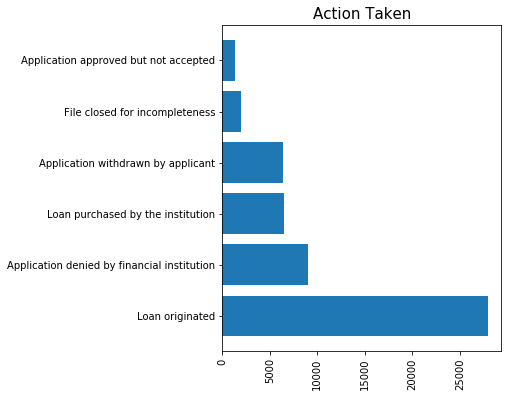

In [18]:
value_counts_bar(hmda_df.action_taken_name, "Action Taken")

<br/>

__&bull; Agency__

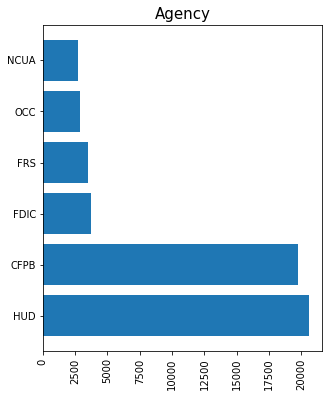

In [19]:
value_counts_bar(hmda_df.agency_abbr, "Agency")

<br/>

__&bull; Applicant Race__

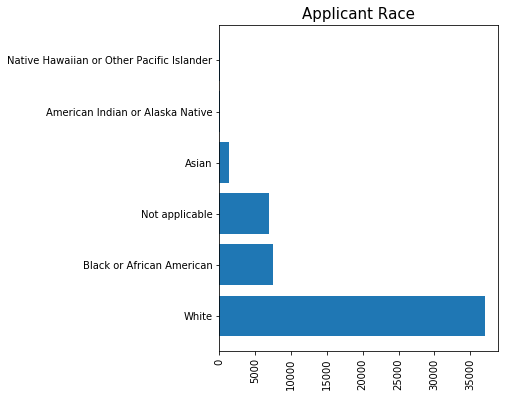

In [20]:
value_counts_bar(hmda_df.applicant_race_name_1, "Applicant Race")

While White is the majority, Pacific Islander and American Indian are very small enough to be tied together with other minorities.

In [21]:
hmda_df['applicant_race_name_1'] = hmda_df['applicant_race_name_1'].apply(lambda x : "Others" 
                                            if x != "White" and x != "Black or African American" else x)

<br/>

__&bull; Applicant Sex__

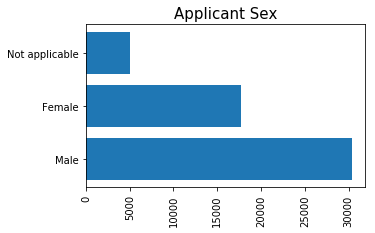

In [22]:
value_counts_bar(hmda_df.applicant_sex_name, "Applicant Sex")

In [23]:
sex_types = ["No co-applicant", "Female", "Male"]
hmda_df['applicant_sex_name'] = hmda_df['applicant_sex_name'].apply(lambda x : "Others"
                                            if x not in sex_types else x)

<br/>

__&bull; Co-applicant Race__

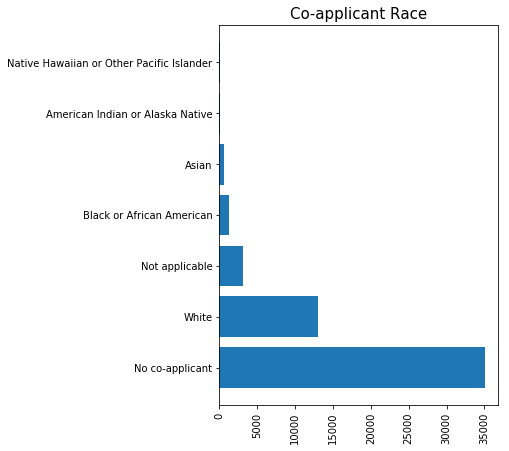

In [24]:
value_counts_bar(hmda_df.co_applicant_race_name_1, "Co-applicant Race")

In [25]:
co_race_major = ['No co-applicant', 'White', 'Black or African American']
hmda_df['co_applicant_race_name_1'] = hmda_df['co_applicant_race_name_1'].apply(lambda x : "Others" 
                                            if x not in co_race_major else x)

<br/>

__&bull; Co-applicant Sex__

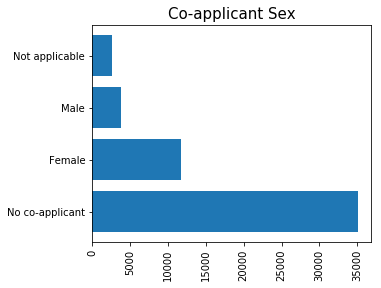

In [26]:
hmda_df['co_applicant_sex_name'] = hmda_df['co_applicant_sex_name'].astype('category')
value_counts_bar(hmda_df.co_applicant_sex_name, "Co-applicant Sex")

In [27]:
hmda_df['co_applicant_sex_name'] = hmda_df['co_applicant_sex_name'].apply(lambda x : "Others"
                                            if x not in sex_types else x)

<br/>

__&bull; Loan Purpose__

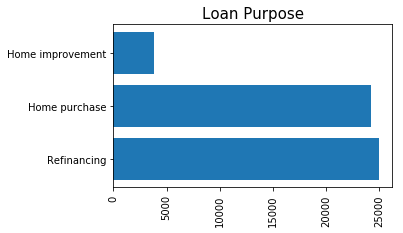

In [28]:
value_counts_bar(hmda_df.loan_purpose_name, "Loan Purpose")

<br/>

__&bull; Loan Type__

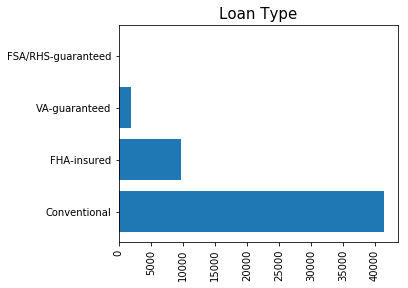

In [29]:
value_counts_bar(hmda_df.loan_type_name, "Loan Type")

In [30]:
hmda_df['loan_type_name'] = hmda_df['loan_type_name'].apply(lambda x : "VA/FSA/RHS-guaranteed" 
                                        if x != "Conventional" and x != "FHA-insured" else x)

<br/>

__&bull; Owner Occupancy__

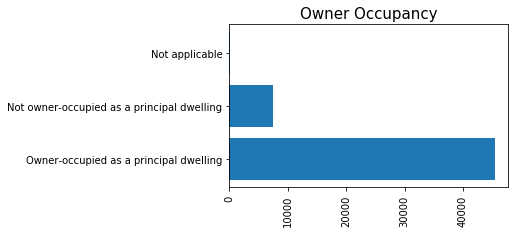

In [31]:
value_counts_bar(hmda_df.owner_occupancy_name, "Owner Occupancy")

In [32]:
hmda_df['owner_occupancy_name'] = hmda_df['owner_occupancy_name'].apply(lambda x : "Not owner-occupied" 
                                            if x != "Owner-occupied as a principal dwelling" else x)
hmda_df['owner_occupancy_name'] = hmda_df['owner_occupancy_name'].apply(lambda x : "Owner-occupied"
                                            if x != "Not owner-occupied" else x)

<br/>

__&bull; Census Tract Number__

In [33]:
hmda_df = hmda_df[hmda_df['census_tract_number'] != ""]
print("Number of Census Tract:", len(hmda_df['census_tract_number'].unique()))

Number of Census Tract: 105


Census tract numbers are not numerical data as their ratios do not mean anything. [St. Louis Census Tract Number on Map](https://censusreporter.org/profiles/14000US29510118400-census-tract-1184-st-louis-mo/) can help to understand what they mean and how they are numbered. However, they can be automatically deemed as categorical data since there are over a hundred different values. In fact, we might still use it as categorical data but this could cause overfitting issues. The best way to deal with this is clustering. This technique, though, requires us to know about the data set first as we have yet to know what based we should cluster them on.

<br/>

__&bull; Type Conversion and Summary__

In [34]:
object_cols = list(hmda_df.select_dtypes('object').columns)
object_cols.remove('census_tract_number')
hmda_df[object_cols] = hmda_df[object_cols].astype('category')

In [28]:
hmda_df.describe(include=['category']).drop('count').T

,unique,top,freq
action_taken_name,6,Loan originated,27975
agency_abbr,6,HUD,20547
applicant_race_name_1,3,White,37057
applicant_sex_name,3,Male,30349
co_applicant_race_name_1,4,No co-applicant,35062
co_applicant_sex_name,4,No co-applicant,35062
loan_purpose_name,3,Refinancing,25021
loan_type_name,3,Conventional,41482
owner_occupancy_name,2,Owner-occupied,45485


------

## 3. Data Analysis
As plotting data always comes in handy to feel the data, scatterplot and boxplot will be used as data visualization. Before them, we need to know the distribution for numerical data. If they are overly skewed or they have strange patterns, they should be handled first. Because our target values are mostly approval or denial, it would give us some direction for modeling if we investigate approval rates. This requires grouping, and the finest grouping could be based on census tract numbers.

In [35]:
# approval vs. denial rate
hmda_df['approved'] = hmda_df['action_taken_name'].apply(lambda x : 1 
                            if x == 'Loan originated' else 0)
hmda_df['denied'] = hmda_df['action_taken_name'].apply(lambda x : 1 
                            if x == 'Application denied by financial institution' else 0)

census_approved = hmda_df.groupby(['census_tract_number'])['approved'].mean()
census_denied = hmda_df.groupby(['census_tract_number'])['denied'].mean()

hmda_df['approved'] = hmda_df['census_tract_number'].apply(lambda x : census_approved[x])
hmda_df['denied'] = hmda_df['census_tract_number'].apply(lambda x : census_denied[x])

In [30]:
hmda_df.drop(['census_tract_number', 'as_of_year'], axis=1).describe().drop('count').T

,mean,std,min,25%,50%,75%,max
applicant_income_000s,88.722161,109.317062,1.000000,42.000000,64.000000,103.000000,6679.000000
loan_amount_000s,139.670895,103.516567,1.000000,78.000000,120.000000,174.000000,3200.000000
approved,0.526489,0.098399,0.138889,0.511692,0.554311,0.577465,0.636678
denied,0.168608,0.107960,0.073074,0.117066,0.133333,0.173437,0.694444


The statistics are already showing some problems with dollar-related features that the max is too much compared with 75 quantile. This means the observations are highly skewed. On the contrary, approval rates are showing strong evidence that census tract numbers are good indicators because their approval rates have gaps each other.

------

### Histogram

In [36]:
def numerical_hist(col, bins, lim, title):
    plt.figure(figsize=(6,5))
    plt.hist(col, bins=bins)
    plt.axvline(x=col.mean(), color='red', linestyle='--', linewidth=1)
    plt.title(title + " Distribution", fontsize=15)
    plt.xlabel("Thousand $")
    plt.ylabel("Count")
    plt.xlim([0, lim])
    plt.show()

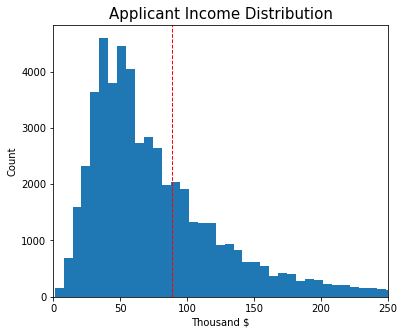

In [37]:
numerical_hist(hmda_df.applicant_income_000s, 1000, 250, "Applicant Income")

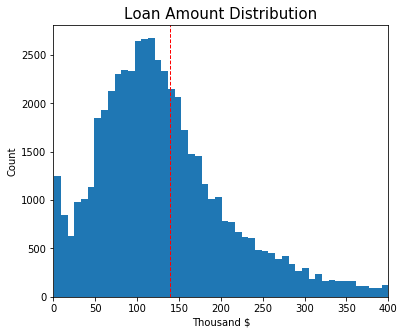

In [38]:
numerical_hist(hmda_df.loan_amount_000s, 400, 400, "Loan Amount")

As seen on the statistics table, the numerical data are skewed as dollar amounts get bigger. However, these do not look like they need a transformation, but they would rather cut off skewed tail as outliers as these extremes values do not make sense. Another problem with only the loan amount feature has is that there are too many zeros, which is also not normal. This must be a loan transaction that would merely exist for administrative purposes, thus, they need to be gone too.

In [39]:
hmda_df = hmda_df[hmda_df['applicant_income_000s'] < 250]
hmda_df = hmda_df[(hmda_df['loan_amount_000s'] > 0) & (hmda_df['loan_amount_000s'] < 400)]
hmda_df.shape

(50544, 15)

In [40]:
print("Average Income: $", round(hmda_df['applicant_income_000s'].mean(), 3), "K")
print("Average Loan Amount: $", round(hmda_df['loan_amount_000s'].mean(), 3), "K")

Average Income: $ 74.039 K
Average Loan Amount: $ 128.423 K


Compared with the red lines on the plots, the averages are a bit lowers after outliers are removed. The following table shows correlations. It is not surprising approved and denied are highly correlated since results are mostly either of them. Also, income and loan amount are positively related, which seems to be normal. However, it is not what someone would expect that bigger loan amounts have higher chances of approval. The reasoning for this can be because loan amount is correlated with income and high income usually guarantees approval.

In [41]:
hmda_df.drop(['census_tract_number', 'as_of_year'], axis=1).corr()

,applicant_income_000s,loan_amount_000s,approved,denied
applicant_income_000s,1.000000,0.469093,0.215821,-0.227778
loan_amount_000s,0.469093,1.000000,0.355519,-0.372894
approved,0.215821,0.355519,1.000000,-0.961708
denied,-0.227778,-0.372894,-0.961708,1.000000


------

### &bull; Scatterplot

Text(0.5,1,'Income vs. Loan Amount by Race')

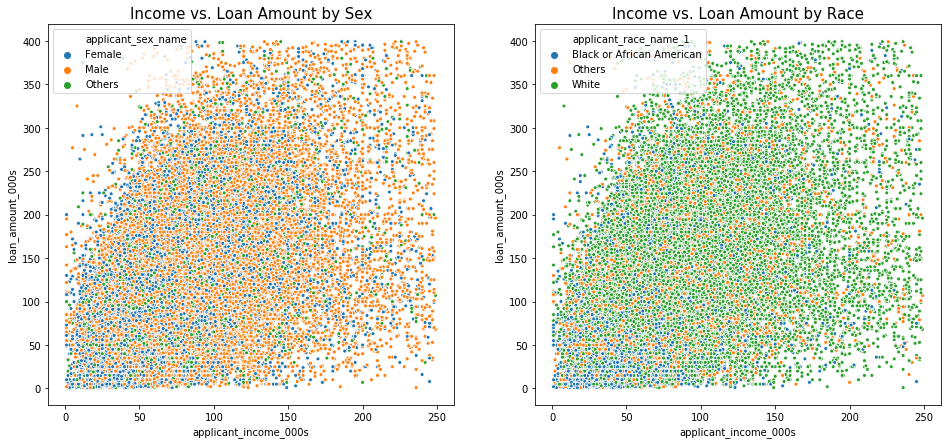

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.scatterplot(x="applicant_income_000s", y="loan_amount_000s", 
                data=hmda_df, hue="applicant_sex_name", s=15, ax=axes[0])
axes[0].set_title("Income vs. Loan Amount by Sex", fontsize=15)

sns.scatterplot(x="applicant_income_000s", y="loan_amount_000s", 
                data=hmda_df, hue="applicant_race_name_1", s=15, ax=axes[1])
axes[1].set_title("Income vs. Loan Amount by Race", fontsize=15)

There seems almost not effect of sex on income vs. loan amount, although it looks like there are relatively more females whose income and loan amount are smaller. The similar story goes to racial factors. While there is no specific pattern, a mild trend is seen in low-income and low-loan amount area that black people are relatively more. The following is to survey the rest of categorical features based on approval rates.

In [43]:
# jitter to show limited number of census tract without overlaps
hmda_df_jitter = hmda_df
hmda_df_jitter['approved'] = hmda_df_jitter['approved'].apply(lambda x : x+np.random.uniform(-0.02, 0.02))
hmda_df_jitter['denied'] = hmda_df_jitter['denied'].apply(lambda x : x+np.random.uniform(-0.02, 0.02))

Text(0.5,1,'Approval Rate by Co-applicant Sex')

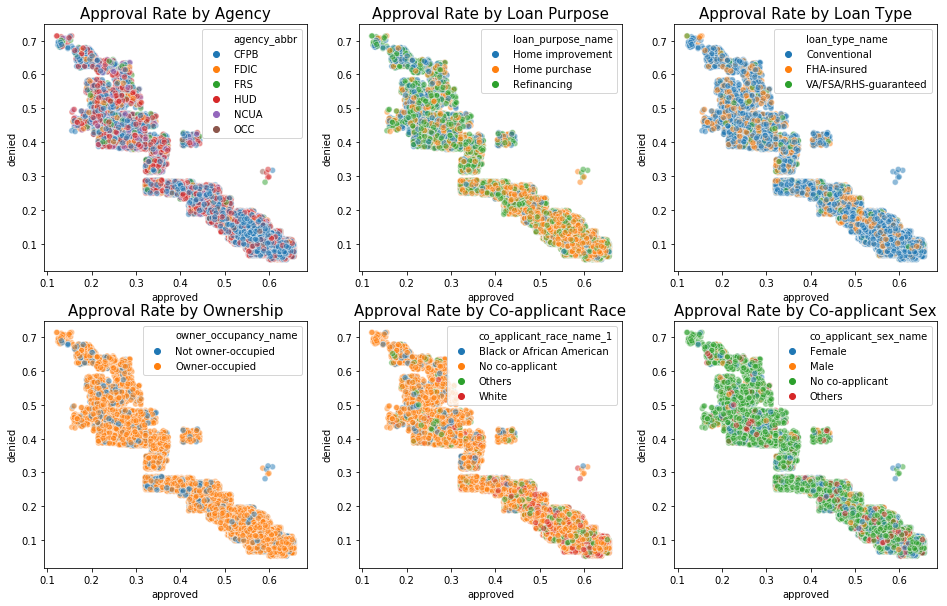

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# agency
sns.scatterplot(x="approved", y="denied", data=hmda_df_jitter, 
                hue="agency_abbr", alpha=0.5, ax=axes[0,0])
axes[0,0].set_title("Approval Rate by Agency", fontsize=15)
# loan purpose
sns.scatterplot(x="approved", y="denied", data=hmda_df_jitter, 
                hue="loan_purpose_name", alpha=0.5, ax=axes[0,1])
axes[0,1].set_title("Approval Rate by Loan Purpose", fontsize=15)
# loan type
sns.scatterplot(x="approved", y="denied", data=hmda_df_jitter, 
                hue="loan_type_name", alpha=0.5, ax=axes[0,2])
axes[0,2].set_title("Approval Rate by Loan Type", fontsize=15)
# ownership
sns.scatterplot(x="approved", y="denied", data=hmda_df_jitter, 
                hue="owner_occupancy_name", alpha=0.5, ax=axes[1,0])
axes[1,0].set_title("Approval Rate by Ownership", fontsize=15)
# co-applicant race
sns.scatterplot(x="approved", y="denied", data=hmda_df_jitter, 
                hue="co_applicant_race_name_1", alpha=0.5, ax=axes[1,1])
axes[1,1].set_title("Approval Rate by Co-applicant Race", fontsize=15)
# co-applicant sex
sns.scatterplot(x="approved", y="denied", data=hmda_df_jitter, 
                hue="co_applicant_sex_name", alpha=0.5, ax=axes[1,2])
axes[1,2].set_title("Approval Rate by Co-applicant Sex", fontsize=15)

Most of the features have the same issue in common that there is a dominant value and the rest account for a small portion. For example, agency CFPB is drawn all over while the rest are hardly seen. Even so, it seems like other agengies are generally worse in terms of approval rate as they are located high-denied and low-approved area. The opposite can explain loan purposes. With refinancing being majority, home purchase is usually relatively approved. As for the rest, there do not seem a noticible trend.

------

### &bull; Boxplot
The purpose of boxplot for this project is to see if categorical data can work for classification by interacting with numerical data. Therefore, a categorical value measured differently by numerical data is likely helpful to distinguish classes. We want to go through some of the categorical data that showed certain patterns.

In [44]:
""" draw boxplot by category and loan results """
def category_boxplot(cate, title):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    # income
    sns.boxplot(x=cate, y="applicant_income_000s", hue="action_taken_name", 
                data=hmda_df, ax=axes[0])
    axes[0].set_title("Income by " + title, fontsize=15)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2)
    # loan amount
    sns.boxplot(x=cate, y="loan_amount_000s", hue="action_taken_name", 
                data=hmda_df, ax=axes[1])
    axes[1].set_title("Loan Amount by " + title, fontsize=15)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2)

    plt.tight_layout()

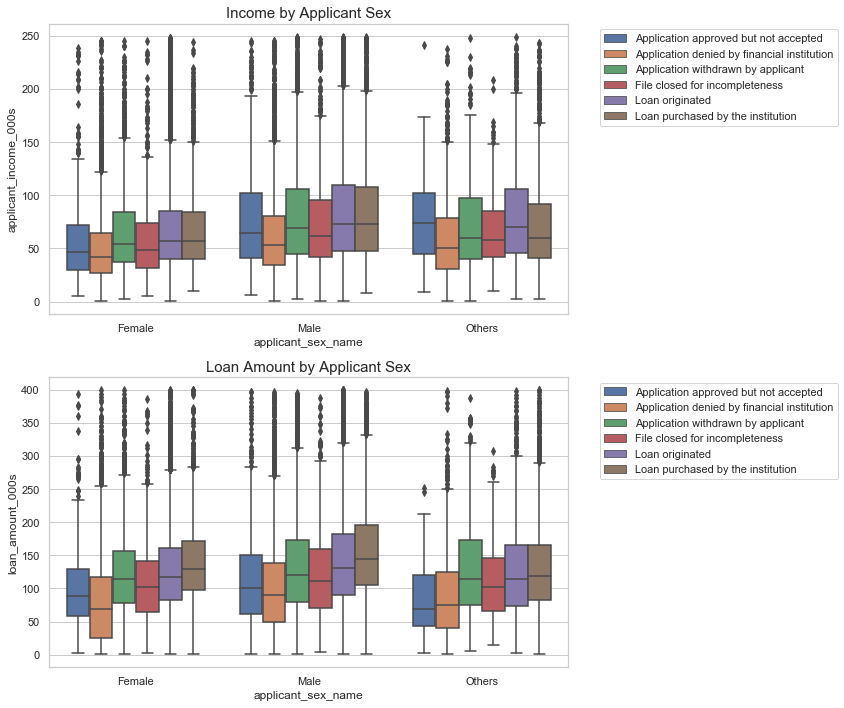

In [45]:
# applicant sex
category_boxplot("applicant_sex_name", "Applicant Sex")

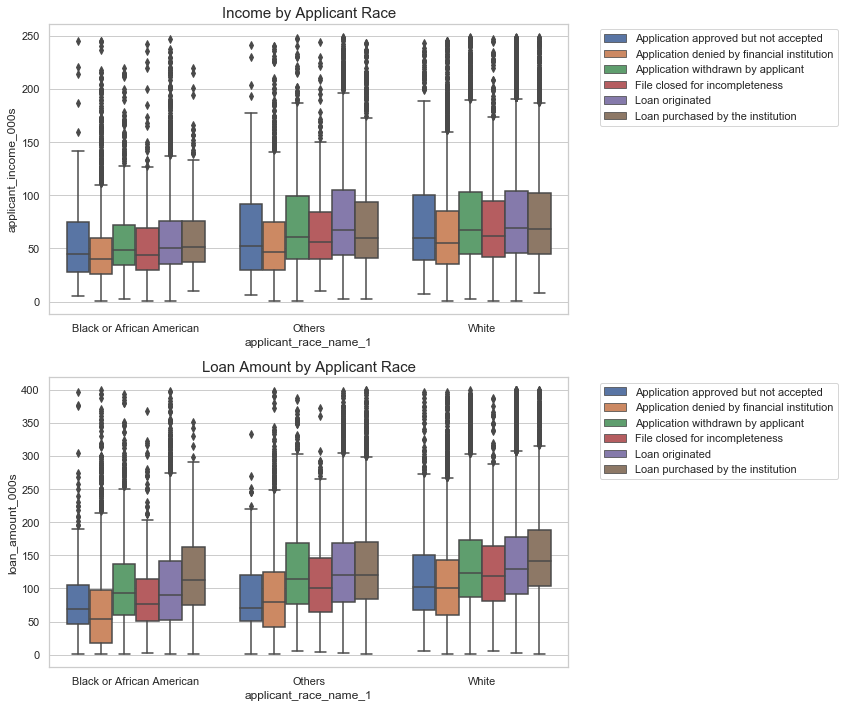

In [46]:
# applicant race
category_boxplot("applicant_race_name_1", "Applicant Race")

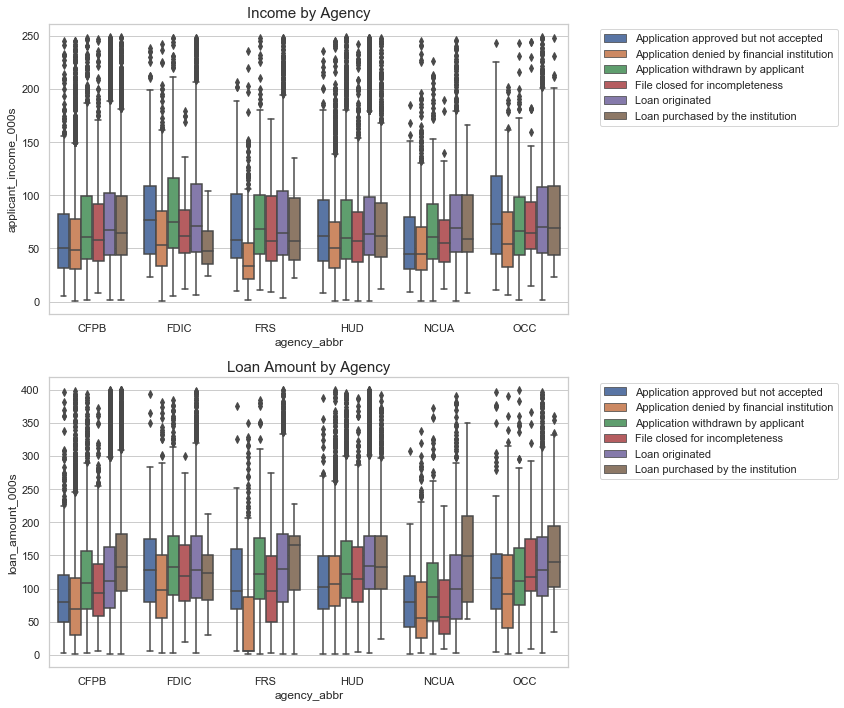

In [47]:
# agency
category_boxplot("agency_abbr", "Agency")

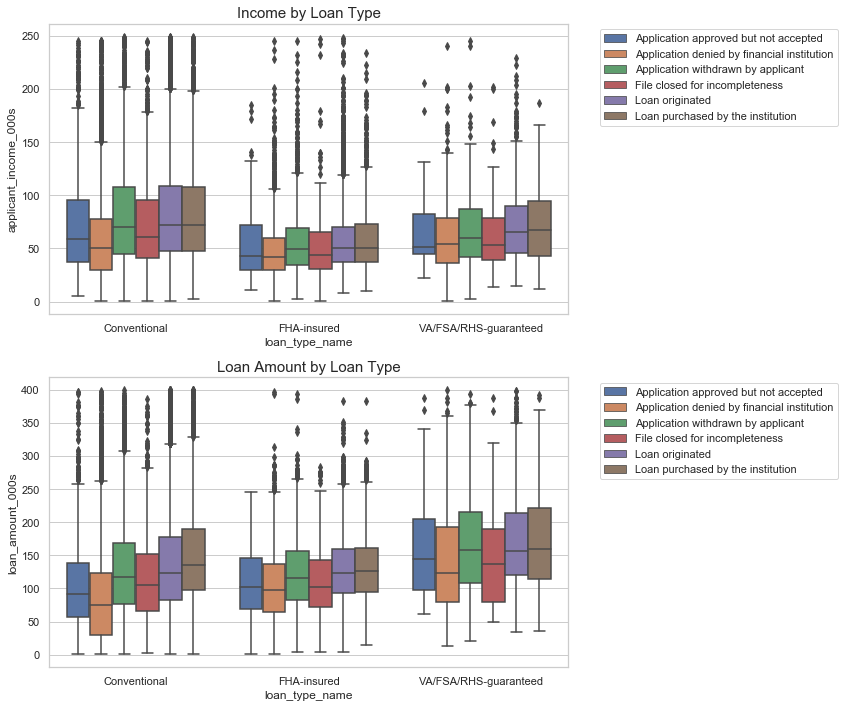

In [48]:
# loan type
category_boxplot("loan_type_name", "Loan Type")

------

## 5. Clustering
Now that we have found out some patterns, we can base them for clustering census tract numbers. To visualize about a hundred of them, we can draw yet another scatterplots using numerical features. By doing so, we can decide which clustering methods to use. Since often there is no clear standard when it comes to clustering, it is critical to plot data and visually judge what method is most suitable. But we can always go with trial and error.

In [49]:
# criteria 1 based on loan approval rate
census_appr = hmda_df.groupby(['census_tract_number'])['approved'].mean()
census_deni = hmda_df.groupby(['census_tract_number'])['denied'].mean()
census_df_1 = pd.DataFrame({'approved': census_appr, 'denied': census_deni})
census_df_1.reset_index(inplace=True)

# criteria 2 based on income vs. loan amount
census_income = hmda_df.groupby(['census_tract_number'])['applicant_income_000s'].mean()
census_loan_amount = hmda_df.groupby(['census_tract_number'])['loan_amount_000s'].mean()
census_df_2 = pd.DataFrame({'income': census_income, 'loan_amount': census_loan_amount})
census_df_2.reset_index(inplace=True)

# merge criteria 1 and 2
census_df = pd.merge(census_df_1, census_df_2)

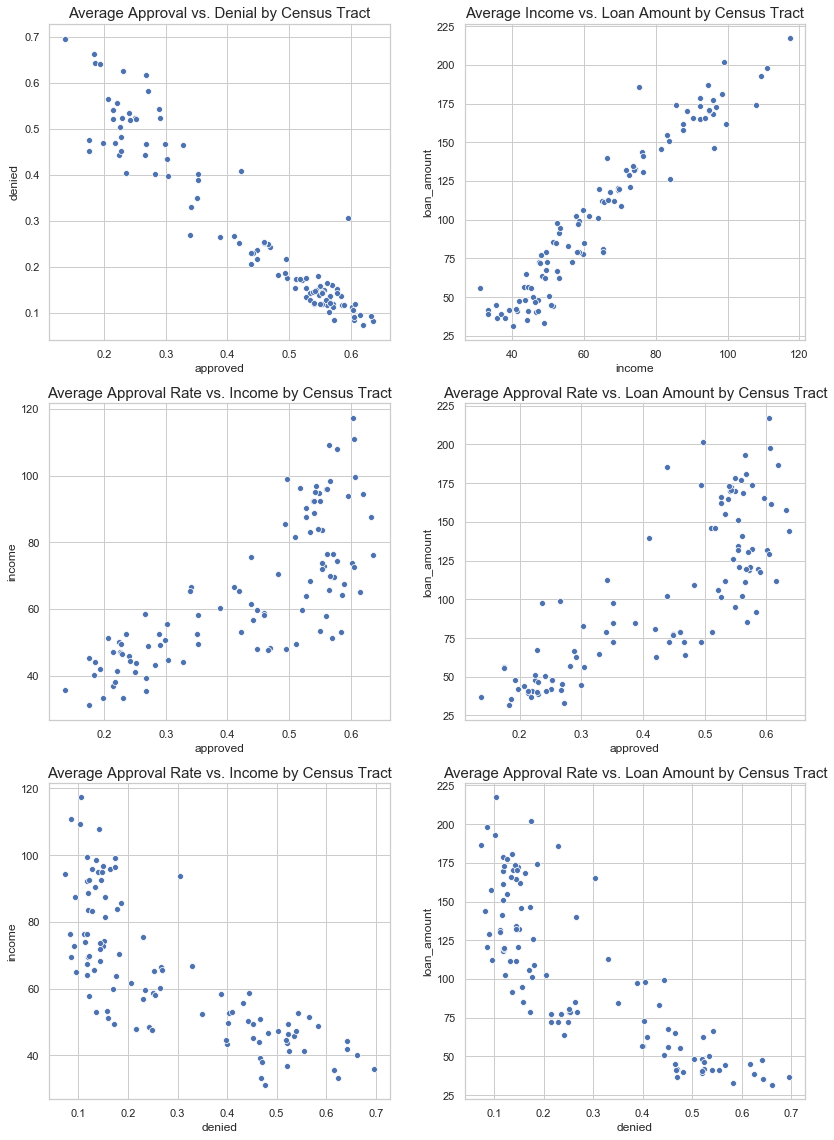

In [44]:
# combination of numerical data
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

sns.scatterplot(x="approved", y="denied", data=census_df, ax=axes[0,0])
axes[0,0].set_title("Average Approval vs. Denial by Census Tract", fontsize=15)

sns.scatterplot(x="income", y="loan_amount", data=census_df, ax=axes[0,1])
axes[0,1].set_title("Average Income vs. Loan Amount by Census Tract", fontsize=15)

sns.scatterplot(x="approved", y="income", data=census_df, ax=axes[1,0])
axes[1,0].set_title("Average Approval vs. Income by Census Tract", fontsize=15)

sns.scatterplot(x="approved", y="loan_amount", data=census_df, ax=axes[1,1])
axes[1,1].set_title("Average Approval vs. Loan Amount by Census Tract", fontsize=15)

sns.scatterplot(x="denied", y="income", data=census_df, ax=axes[2,0])
axes[2,0].set_title("Average Denial vs. Income by Census Tract", fontsize=15)

sns.scatterplot(x="denied", y="loan_amount", data=census_df, ax=axes[2,1])
axes[2,1].set_title("Average Denial vs. Loan Amount by Census Tract", fontsize=15)

plt.tight_layout()

The first, approval vs. denial, is seemingly dividable into two or so. But the second, income vs. loan amount, is only showing a strong relationship between them, not groups. As for the rest, they all have some groups, but we can see some strong grouping on the last, loan amount vs. denial, in the sense of density, which differentiate the combination from the others.

------

### &bull; Hierarchical Clustering: *Dendrogram*

The utmost advantage of hierarchical clustering is that it gives a general idea of how many groups in the data. Especially, dendrogram is very useful to see it visually. First, we can use the approval rate plot (first from the previous plots) for this method as we focus on distance.

In [53]:
X = [[x[0], x[1]] for x in zip(census_df['approved'], census_df['denied'])]
X = np.array(X)

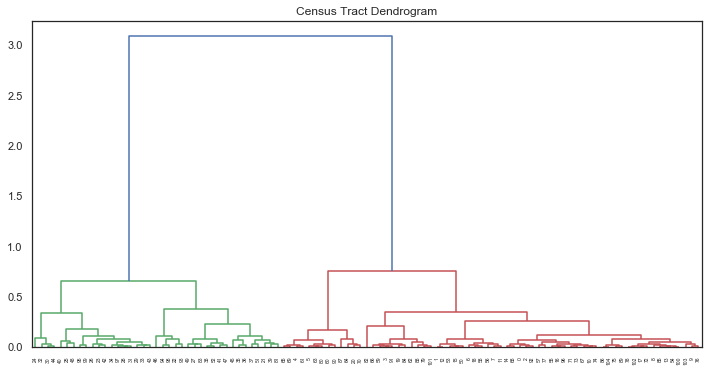

In [46]:
sns.set(style='white')
plt.figure(figsize=(12,6))
plt.title("Census Tract Dendrogram")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

From the dendrogram, it could be a few groups to be clustered into, depending on where to cut off. The bset way is plotting them and iterate some numbers for clustering to decide the number of clusters.

In [51]:
def hier_clustering_labels(X, n):
    clustering = AgglomerativeClustering(
        n_clusters=n, affinity='euclidean', linkage='ward'
    )
    clustering.fit_predict(X)
    
    return clustering.labels_

Text(0.5,1,'Cluster n=5')

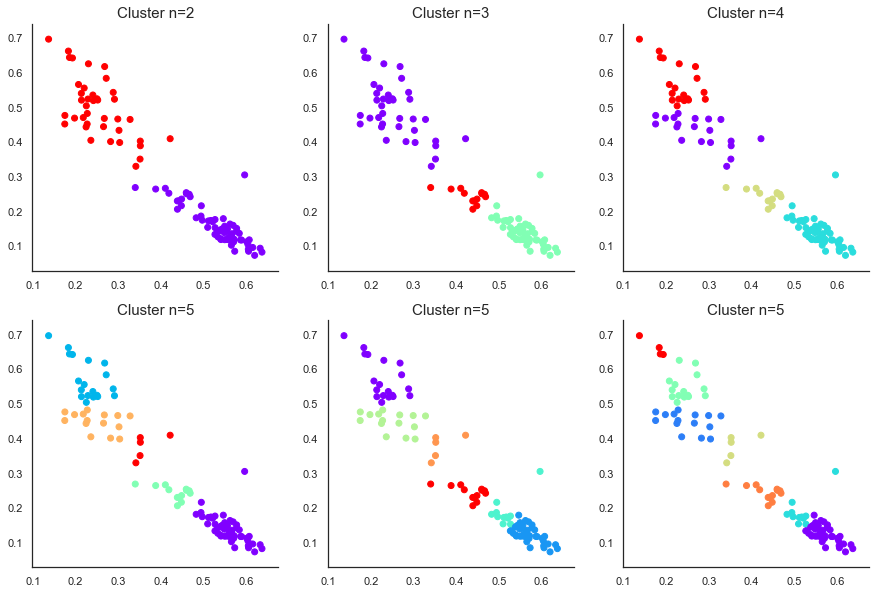

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.despine()

axes[0,0].scatter(X[:,0], X[:,1], c=hier_clustering_labels(X, 2), cmap='rainbow')
axes[0,0].set_title("Cluster n=2", fontsize=15)

axes[0,1].scatter(X[:,0], X[:,1], c=hier_clustering_labels(X, 3), cmap='rainbow')
axes[0,1].set_title("Cluster n=3", fontsize=15)

axes[0,2].scatter(X[:,0], X[:,1], c=hier_clustering_labels(X, 4), cmap='rainbow')
axes[0,2].set_title("Cluster n=4", fontsize=15)

axes[1,0].scatter(X[:,0], X[:,1], c=hier_clustering_labels(X, 5), cmap='rainbow')
axes[1,0].set_title("Cluster n=5", fontsize=15)

axes[1,1].scatter(X[:,0], X[:,1], c=hier_clustering_labels(X, 6), cmap='rainbow')
axes[1,1].set_title("Cluster n=6", fontsize=15)

axes[1,2].scatter(X[:,0], X[:,1], c=hier_clustering_labels(X, 7), cmap='rainbow')
axes[1,2].set_title("Cluster n=7", fontsize=15)

Although they all look okay, 5 clusters seems to be the best. Less than 5 might be a too small number, and it becomes a bit strange when it is over 5. Only issue here is the border between the yellow group and the blue group that are almost contacted each other. Other than that, the clustering looks reasonable.

In [54]:
# create a cluster feature
clusters = dict(zip(census_df['census_tract_number'], hier_clustering_labels(X, 5)))
hmda_df['census_group_1'] = hmda_df['census_tract_number'].apply(lambda x : clusters[x])

------

### &bull; Density Based Clustering: *DBSCAN*
DBSCAN takes a different course than the hierarchical clustering does as previously shown. This method is based on density, which means how closely the dots are located from each other. It needs scailing for better processing beforehand, but the rest are very similar steps as done for hierarchical clustering. That is, plotting and iteration are heavily used to find the best number of clusters. Specifically speaking, finding the best epilon and minimum number of samples is our goal.

In [55]:
X = [[x[0], x[1]] for x in zip(census_df['loan_amount'], census_df['denied'])]
X = np.array(X)
X = ppr.StandardScaler().fit_transform(X)

In [56]:
def db_scan_labels(X, eps, min_samples):
    db_scan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    
    return db_scan.labels_

Text(0.5,1,'eps=0.3, min_sample=7')

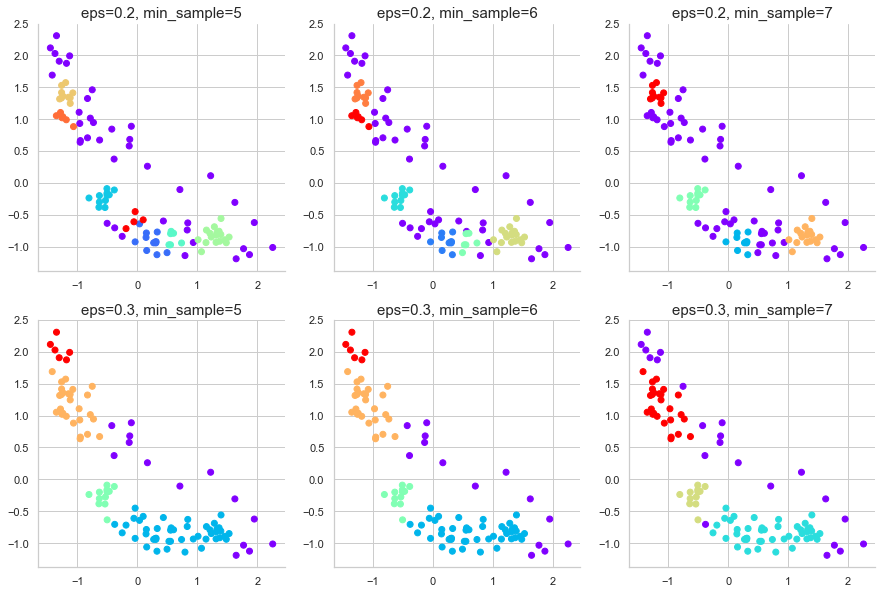

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.despine()

axes[0,0].scatter(X[:,0], X[:,1], c=db_scan_labels(X, 0.2, 5), cmap='rainbow')
axes[0,0].set_title("eps=0.2, min_sample=5", fontsize=15)

axes[0,1].scatter(X[:,0], X[:,1], c=db_scan_labels(X, 0.2, 6), cmap='rainbow')
axes[0,1].set_title("eps=0.2, min_sample=6", fontsize=15)

axes[0,2].scatter(X[:,0], X[:,1], c=db_scan_labels(X, 0.2, 7), cmap='rainbow')
axes[0,2].set_title("eps=0.2, min_sample=7", fontsize=15)

axes[1,0].scatter(X[:,0], X[:,1], c=db_scan_labels(X, 0.3, 5), cmap='rainbow')
axes[1,0].set_title("eps=0.3, min_sample=5", fontsize=15)

axes[1,1].scatter(X[:,0], X[:,1], c=db_scan_labels(X, 0.3, 6), cmap='rainbow')
axes[1,1].set_title("eps=0.3, min_sample=6", fontsize=15)

axes[1,2].scatter(X[:,0], X[:,1], c=db_scan_labels(X, 0.3, 7), cmap='rainbow')
axes[1,2].set_title("eps=0.3, min_sample=7", fontsize=15)

Aware that purple dots are noises, the result of epsilon equal to 0.3 and minimum samples 5 should probably be the best clustering as the others have a couple or more flaws. For example, the second on the first row has a strange cluster in green, and the others have such a point or a group.

In [58]:
# create a cluster feature
clusters = dict(zip(census_df['census_tract_number'], db_scan_labels(X, 0.3, 5)))
hmda_df['census_group_2'] = hmda_df['census_tract_number'].apply(lambda x : clusters[x])

------

### &bull; Evaluation

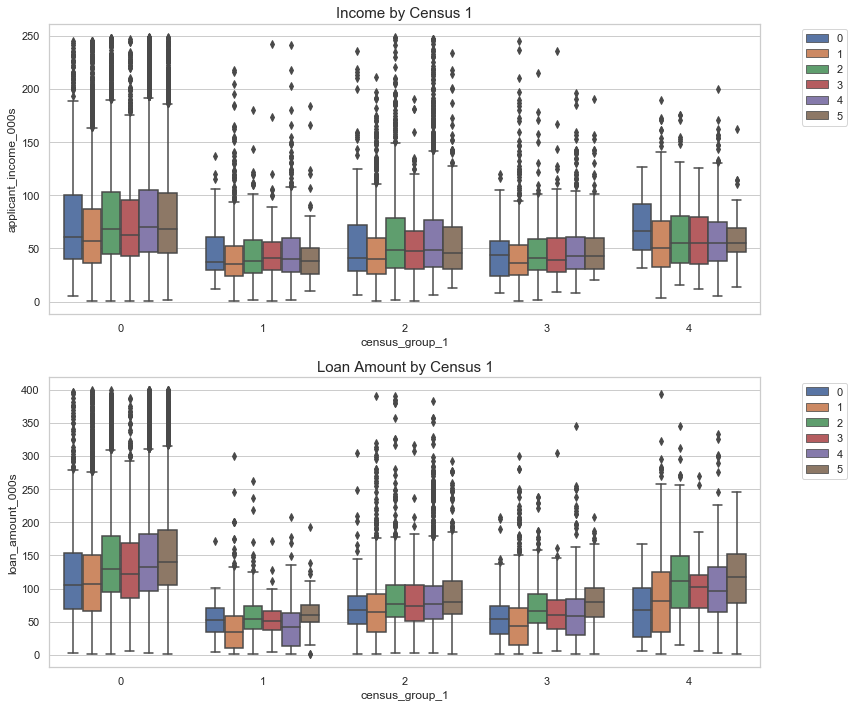

In [176]:
# census group 1
category_boxplot("census_group_1", "Census 1")

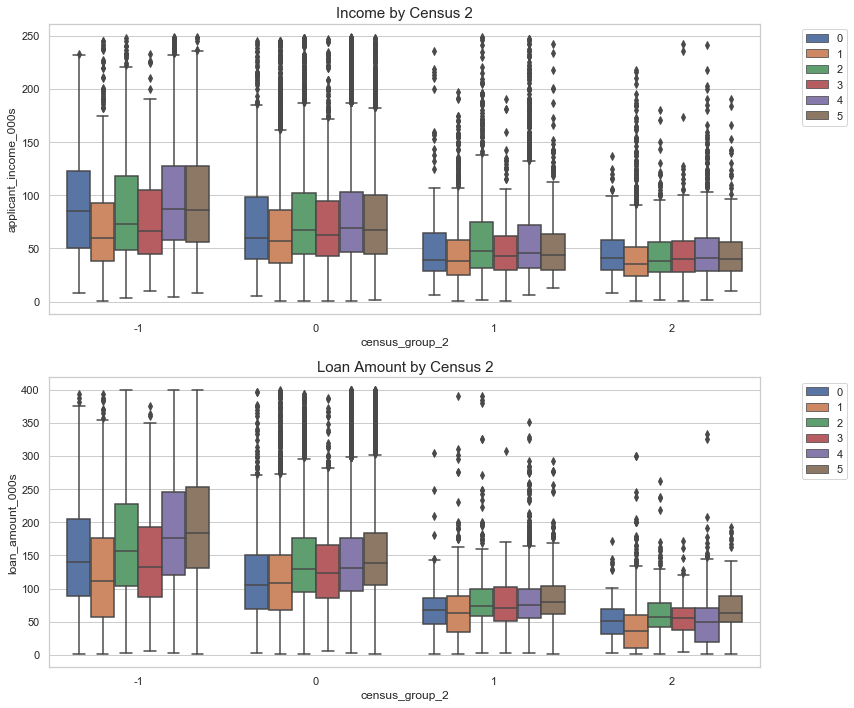

In [177]:
# census group 2
category_boxplot("census_group_2", "Census 2")

------

## 6. Modeling
Our goal is to classify 6 different classes correctly. A possible problem is that they are not equally distributed over the whole data set. For example, cases 'Application approved but not accepted' are a small number in the data. That is, it might need to balance the classes. This can be done by first building a baseline model to find specific classes causing problems.

In [59]:
def split_X_y(df, features, y):
    cate_cols = df.select_dtypes(include='category').columns
    for col in cate_cols:
        le = ppr.LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
    
    X = np.array(df[features])
    y = np.array(df[y])
    
    return X, y

In [116]:
# feature selection
# hmda_df.drop(columns=['approved', 'denied'], inplace=True)
# features = list(hmda_df.columns)
# features.remove('action_taken_name')
# features = ['applicant_income_000s', 'loan_amount_000s',
#             'applicant_sex_name', 'applicant_race_name_1',
#             'agency_abbr', 'loan_type_name',
#             'census_group_1', 'census_group_2']

# X, y split
X, y = split_X_y(hmda_df, features, 'action_taken_name')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

<br/>

__&bull; Baseline: Decision Tree__

In [117]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("5-fold Cross Validation Accuracy:", cross_val_score(clf, X, y, cv=5).mean())
print("\nConfusion Matrix\n", confusion_matrix(y_test, pred))
print("\nReport", classification_report(y_test, pred))

5-fold Cross Validation Accuracy: 0.5178471128541713

Confusion Matrix
 [[  20   89   16    8  222   11]
 [  31 1139  156   41 1127  114]
 [  14  270  232   27 1196   98]
 [   9  135   54   30  298   31]
 [  65  884  537   78 5851  543]
 [  10  104   55    9  868  792]]

Report              precision    recall  f1-score   support

          0       0.13      0.05      0.08       366
          1       0.43      0.44      0.44      2608
          2       0.22      0.13      0.16      1837
          3       0.16      0.05      0.08       557
          4       0.61      0.74      0.67      7958
          5       0.50      0.43      0.46      1838

avg / total       0.49      0.53      0.51     15164



The decision tree with all features included does not perform well. It is particularly poor at classifying all others but 'Loan originated (4)', which is the most support. From the report, we can guess that the model is trying to predict just the most common class. Indeed, the accuracy (0.42) is similar with the ratio of that support (8,051) over the total (15,164). The 6 classes are distinctively different in support, however, it could be challenging to balance them out equally. An alternative solution is to reduce the biggest support. Fortunately, 'Loan originated' is alone the biggest so we can downsize it to the second biggest 'Application denied'. It would be still unbalanced but more reasonable in the prediction sense.

In [88]:
hmda_df['action_taken_name'].value_counts()

4    26420
1     8655
5     6291
2     6084
3     1840
0     1254
Name: action_taken_name, dtype: int64

In [98]:
temp['action_taken_name'].value_counts()

4    8655
1    8655
5    6291
2    6084
3    1840
0    1254
Name: action_taken_name, dtype: int64

In [96]:
len(drop_indice)

17765

In [97]:
second_large_supp = len(hmda_df[hmda_df['action_taken_name']==1])
size_drop = len(hmda_df[hmda_df['action_taken_name']==4]) - second_large_supp
drop_indice = np.random.choice(list(hmda_df[hmda_df['action_taken_name']==4].index), 
                               size_drop, replace=False)
temp = hmda_df.loc[~hmda_df.index.isin(drop_indice)]

In [113]:
X, y = split_X_y(temp, features, 'action_taken_name')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [114]:
#clf = RandomForestClassifier(max_depth=10)
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("5-fold Cross Validation Accuracy:", cross_val_score(clf, X, y, cv=5).mean())
print("\nConfusion Matrix\n", confusion_matrix(y_test, pred))
print("\nReport", classification_report(y_test, pred))

5-fold Cross Validation Accuracy: 0.4117594755841966

Confusion Matrix
 [[   5  110   14    1  160   61]
 [  27 1298  117    5  734  386]
 [  11  444  128    4  977  259]
 [   4  175   41    2  232  102]
 [  23  430  138    2 1734  332]
 [   7  275   49    0  545 1002]]

Report              precision    recall  f1-score   support

          0       0.06      0.01      0.02       351
          1       0.48      0.51      0.49      2567
          2       0.26      0.07      0.11      1823
          3       0.14      0.00      0.01       556
          4       0.40      0.65      0.49      2659
          5       0.47      0.53      0.50      1878

avg / total       0.38      0.42      0.38      9834



In [153]:
[x for x in zip(features, clf.feature_importances_)]

[('agency_abbr', 0.053376558168048205),
 ('applicant_income_000s', 0.141923783573866),
 ('applicant_race_name_1', 0.03314219967563829),
 ('applicant_sex_name', 0.026729967230671902),
 ('as_of_year', 0.052906786382738144),
 ('census_tract_number', 0.09217679053870494),
 ('co_applicant_race_name_1', 0.013058692948356935),
 ('co_applicant_sex_name', 0.03181127507737442),
 ('loan_amount_000s', 0.16039619743805636),
 ('loan_purpose_name', 0.027342252280115695),
 ('loan_type_name', 0.021115458388976778),
 ('owner_occupancy_name', 0.011614671748803701),
 ('approved', 0.15811130749603391),
 ('denied', 0.16397378613991007),
 ('census_group_1', 0.0033014465963122435),
 ('census_group_2', 0.009018826316392439)]

------

## 7. Conclusion

------

## Reference

[metadata1](https://cfpb.github.io/api/hmda/fields.html)
[metadata2](https://www.ffiec.gov/hmda/glossary.htm)
[urllib3 Json](https://urllib3.readthedocs.io/en/latest/user-guide.html)
[PyMongo Tutorial](http://api.mongodb.com/python/current/tutorial.html)
[MongoDB Insert](https://www.w3schools.com/python/python_mongodb_insert.asp)
[PyMongo DB to CSV](https://gist.github.com/mieitza/5d35d0a4f2671127f7120c75c8764385)
[Census Tract](https://censusreporter.org/profiles/14000US29510118400-census-tract-1184-st-louis-mo/)
[Hierarchical Clustering](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)